In [1]:
from importlib import reload
import cartpole_lab.charts
reload(cartpole_lab.charts)

import numpy as np
import gym
import cartpole_lab.agent
import cartpole_lab.deeprico
import cartpole_lab.approximator
reload(cartpole_lab.agent)
reload(cartpole_lab.deeprico)
reload(cartpole_lab.approximator)
from cartpole_lab.deeprico import deep_rico
from cartpole_lab.deepqben import deep_ben

env = gym.make('CartPole-v1')
observation = env.reset()

Using TensorFlow backend.


avg of last 100 episodes: 123.561224


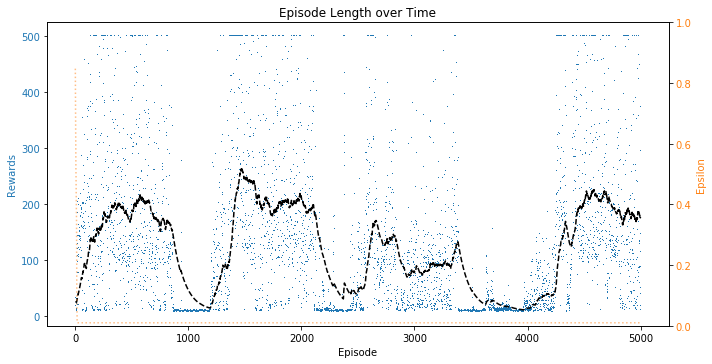

In [5]:
agent = deep_rico(env)
agent.train(5000)

After removing the ```if done: rewards = -rewards``` bit:

avg of last 100 episodes: 139.283784


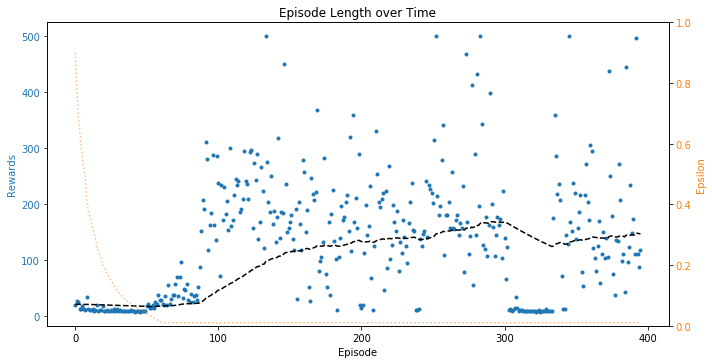

In [ ]:
agent = deep_rico(env)
agent.train(5000)

In [8]:
agent.demo()

score= 451.0
score= 99.0
score= 32.0
score= 97.0
score= 41.0
score= 26.0
score= 93.0
score= 136.0
score= 60.0
score= 44.0
Avg rewards= 107.9


avg of last 100 episodes: 12.411111


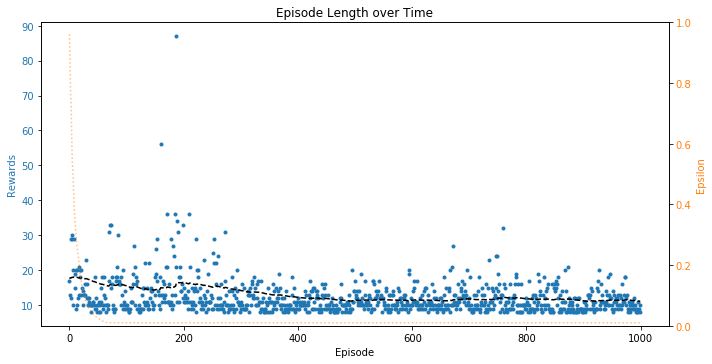

In [2]:
ben = cartpole_lab.deepqben.deep_ben(env)
ben.train(1000)

In [4]:
agent = deep_rico(env)
agent.policy.load()
agent.demo()

score= 16.0
score= 25.0
score= 51.0
score= 27.0
score= 9.0
score= 14.0
score= 12.0
score= 12.0
score= 12.0
score= 12.0
Avg rewards= 19.0


In [5]:
env.close()

In [ ]:
ben = cartpole_lab.deepqben.deep_ben(env)
ben.train(200)

In [ ]:
agent = deep_rico(env)
agent.train(1000)